In [2]:
import glam
import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt


from scipy.stats import invgauss

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


In [3]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
np.random.seed(23) # from random.org

In [5]:
sufix = '_Like_FixBin5'

## Attempt with individual model data

In [6]:
data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Like_Bin_v2.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

In [7]:
glam_full = glam.GLAM(data)
glam_full.make_model('individual', gamma_bounds=(-1, 1), t0_val=0)

Generating single subject models for 33 subjects...


In [8]:
glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_individual'+sufix+'.npy'))

In [13]:
#glam_full.estimates

In [14]:
# We can define n_repeats (1 by default), boundary (1 by default), error_weight ( 0.05 by default) 
#glam_full.predict(n_repeats=50)


In [15]:
## Select one participants parameters to perform the simulations
subject = 0
parameters = [glam_full.estimates[subject].get(parameter)
                              for parameter in ['v', 'gamma', 's', 'tau', 't0']]
parameters

[4.1e-05,
 -0.59999999999999998,
 0.0075399999999999998,
 2.1699999999999999,
 array([ 0.])]

In [16]:
value_cols = ['item_value_{}'.format(i)
                          for i in range(glam_full.n_items)]
gaze_cols = ['gaze_{}'.format(i)
                         for i in range(glam_full.n_items)]

In [17]:
values = glam_full.data[value_cols][glam_full.data['subject'] == subject].values
gaze = glam_full.data[gaze_cols][glam_full.data['subject'] == subject].values

rt_min = glam_full.data['rt'][glam_full.data['subject'] == subject].values.min()
rt_max = glam_full.data['rt'][glam_full.data['subject'] == subject].values.max()
error_range = (rt_min, rt_max)

In [19]:
# Parameters for the simulations
n_repeats=50
boundary=1
error_weight=0.05

# Variables to run the simulation (repetitions give by n_repeats) for various trials
n_trials, n_items = values.shape
rts = np.zeros(n_trials * n_repeats) * np.nan
choices = np.zeros(n_trials * n_repeats) * np.nan
trial_idx = np.zeros(n_trials * n_repeats) * np.nan
repeat_idx = np.zeros(n_trials * n_repeats) * np.nan

running_idx = 0


In [20]:
## To run the simulations to various trials (e.g. all trials from subject s)

for trial in range(n_trials):

        for repeat in range(n_repeats):

            choice, rt = glam.simulation.simulate_trial(parameters, values[trial], gaze[trial],
                                        boundary=boundary,
                                        error_weight=error_weight,
                                        error_range=error_range)

            rts[running_idx] = rt
            choices[running_idx] = choice
            trial_idx[running_idx] = trial
            repeat_idx[running_idx] = repeat

            running_idx += 1

## Simulation of individual trial
 Evidence_item_1 (t) = Evidence_item_1 (t-1) + v*R_i + GaussNoise + t0
 
 drifts function delivers the v*Ri component from the accumulutaion equation
 
 FPTs[i] = invgauss.rvs(mu=mu/lam, scale=lam) defines a random sample from a distribution (inverse Gaussian) containing the time of first hit in a barrier for and accumulator el type described above

In [22]:
# using trial 1 for participant selected
trial = 1
value_trial = values[trial]
gaze_trial = gaze[trial]

v, gamma, s, tau, t0 = parameters
n_items = len(values[trial])


# including in the model possibility of random answer (and random RT)
if np.random.uniform(0, 1) < error_weight:
    rt = int(np.random.uniform(*error_range))
    choice = np.random.choice(n_items)
else:
    drifts = glam.simulation.expdrift(v, tau, gamma, value_trial, gaze_trial)
    FPTs = np.zeros(n_items) * np.nan
    for i in range(n_items):
        mu = boundary / drifts[i]
        lam = (boundary / s)**2
        FPTs[i] = invgauss.rvs(mu=mu/lam, scale=lam)
    choice = np.argmin(FPTs)
    rt = int(np.round(np.min(FPTs) + t0))

print([choice, rt])

[0, 1632]


## Simulate trials with selected value conditions

### Using DV = 1 but with different value magnitude

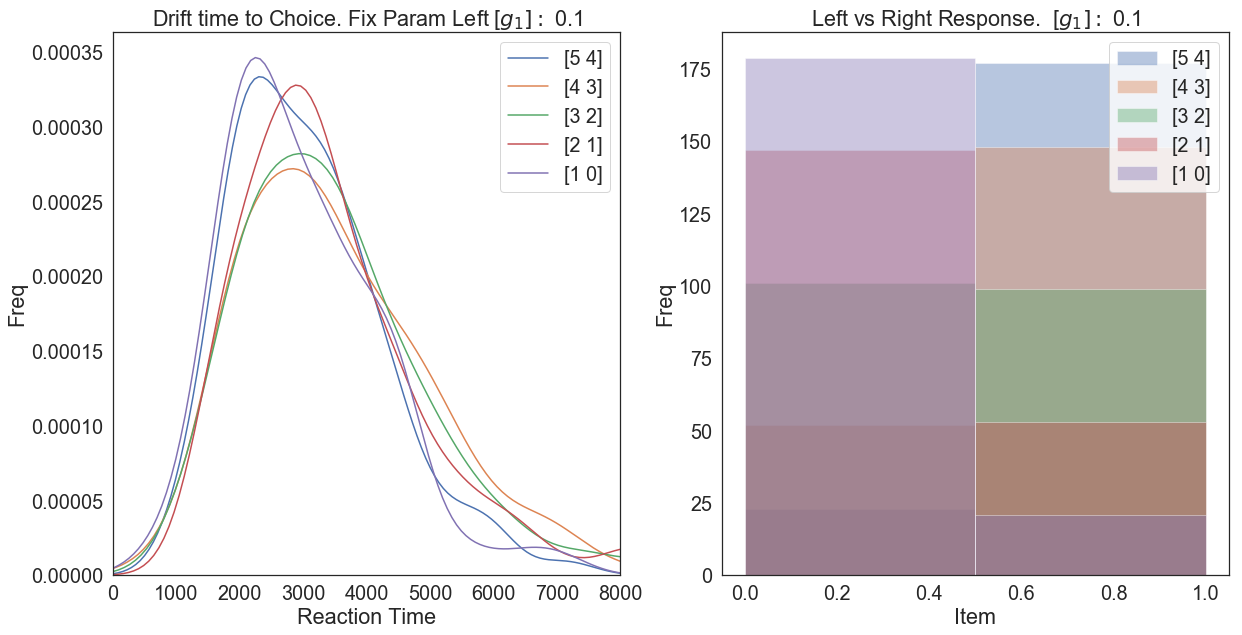

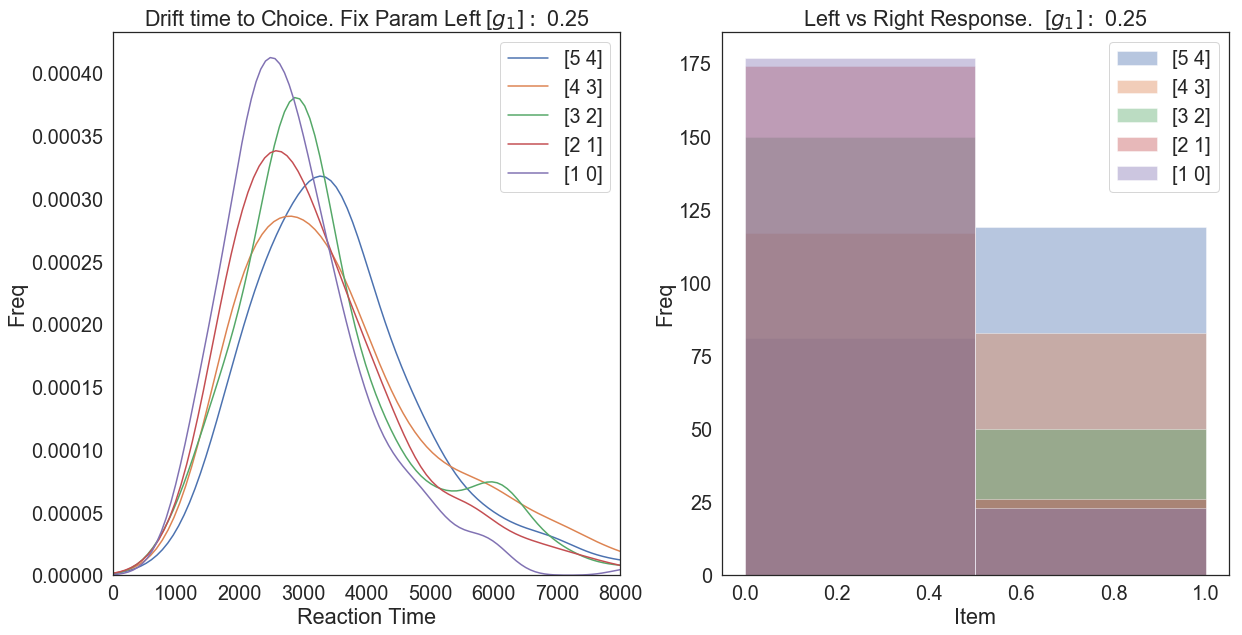

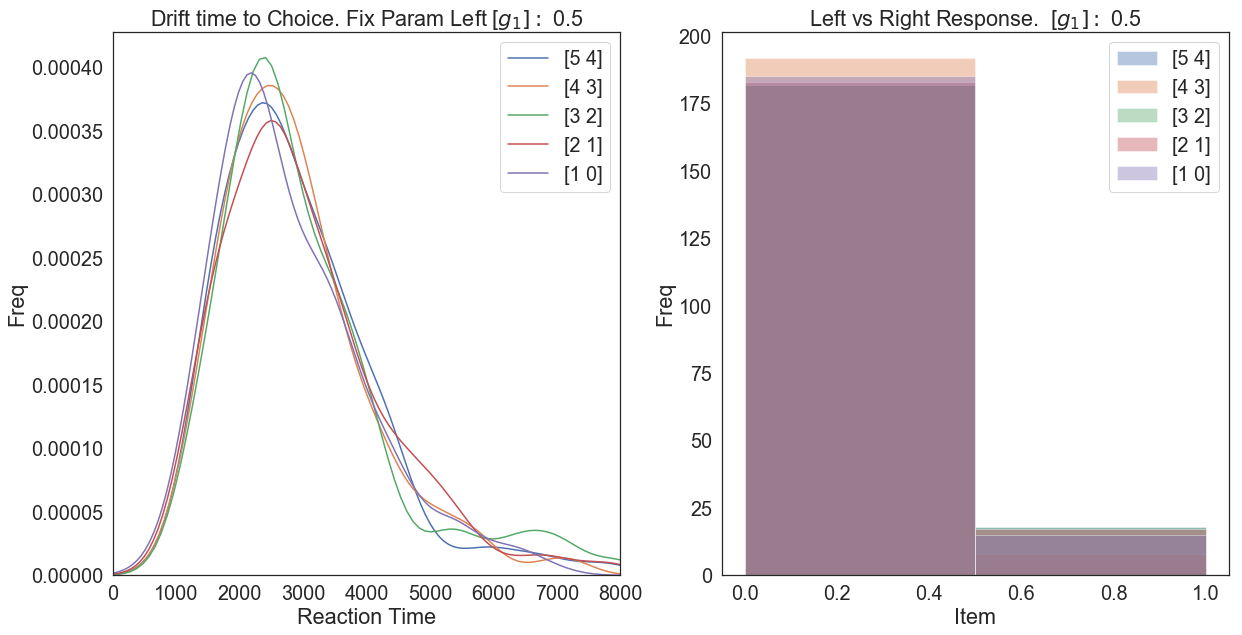

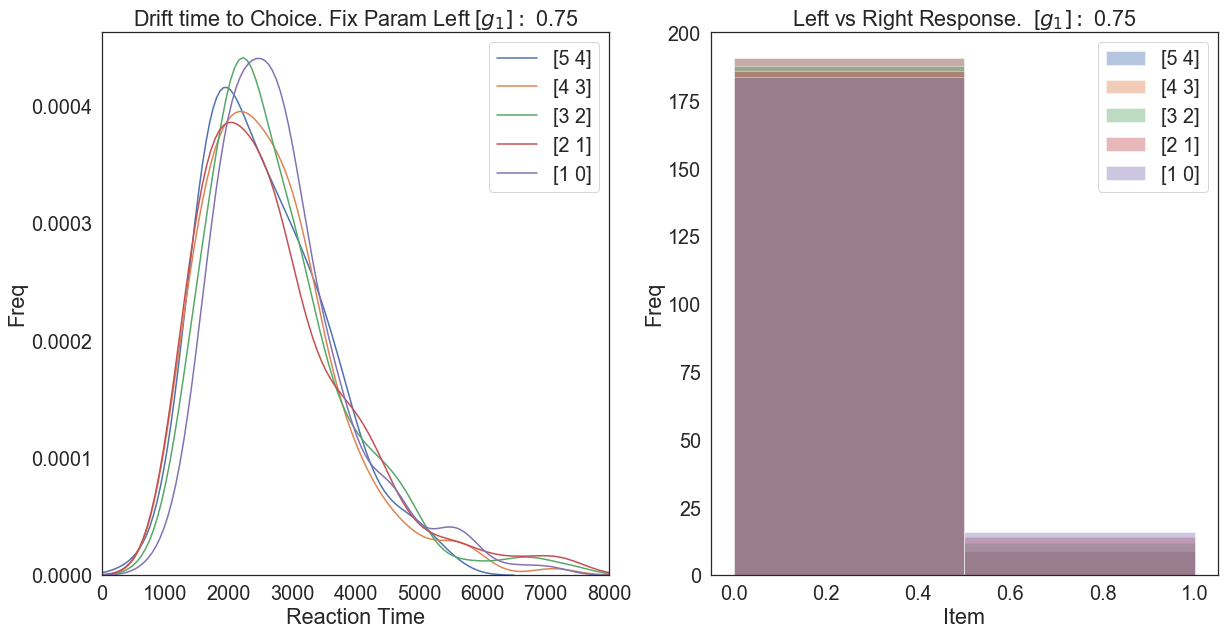

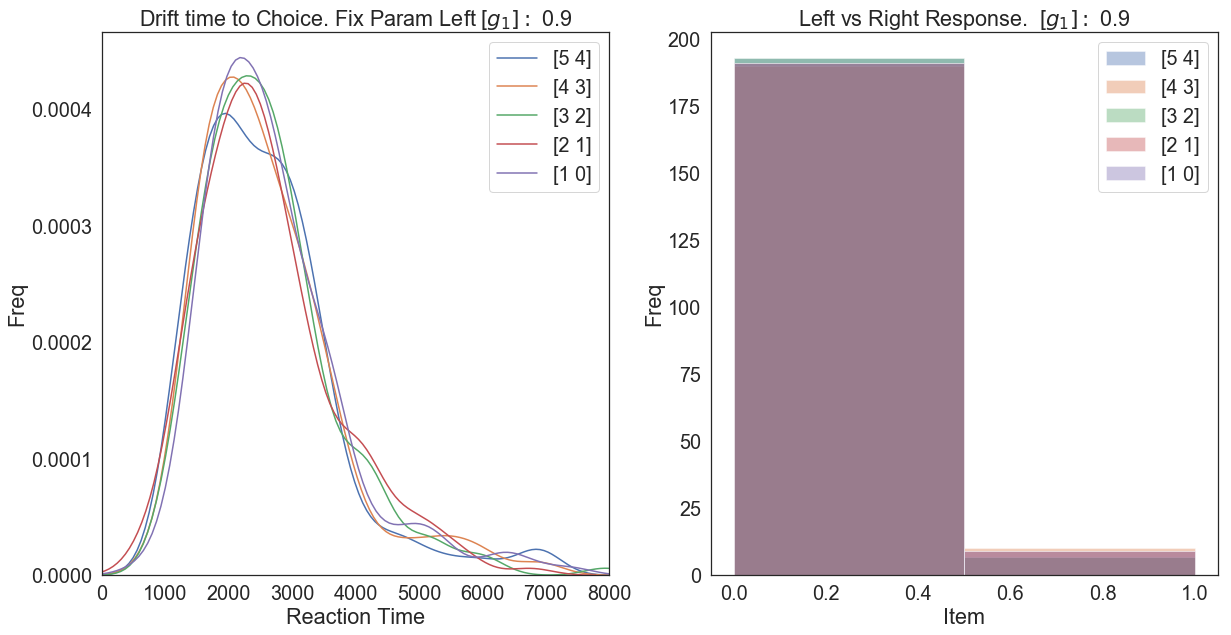

In [35]:
value_tests = np.array([[5,4],[4,3],[3,2],[2,1],[1,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

v , gamma, s, tau, t0 = parameters
gamma = 0.6
tau = 2
parameters = [v , gamma, s, tau, t0]

n_repeats = 200





for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure(figsize=(20,10))
    sns.set(style='white', font_scale=1.8)


    for trial in range(n_trials):
    
        n_trials, n_items = value_tests.shape
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
                
                choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                            boundary=boundary,
                                            error_weight=error_weight,
                                            error_range=error_range)
    
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                
                running_idx += 1
        plt.subplot(121)        
        ax1 = sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
        plt.subplot(122)
        ax2 =sns.distplot(choices,bins=2, kde = False, hist = True, label=str(value_trial));

    #sns.kdeplot(rts)
    
    ax1.set_title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax1.set(ylabel='Freq', xlabel='Reaction Time', xlim = (0, 8000))

    ax2.set_title("Left vs Right Response. "+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax2.set(ylabel='Freq', xlabel='Item')
    #ax2.xticks([0, 1,], ['Left', 'Right'])


    
    ax1.legend();
    ax2.legend();



### Using various DVs 

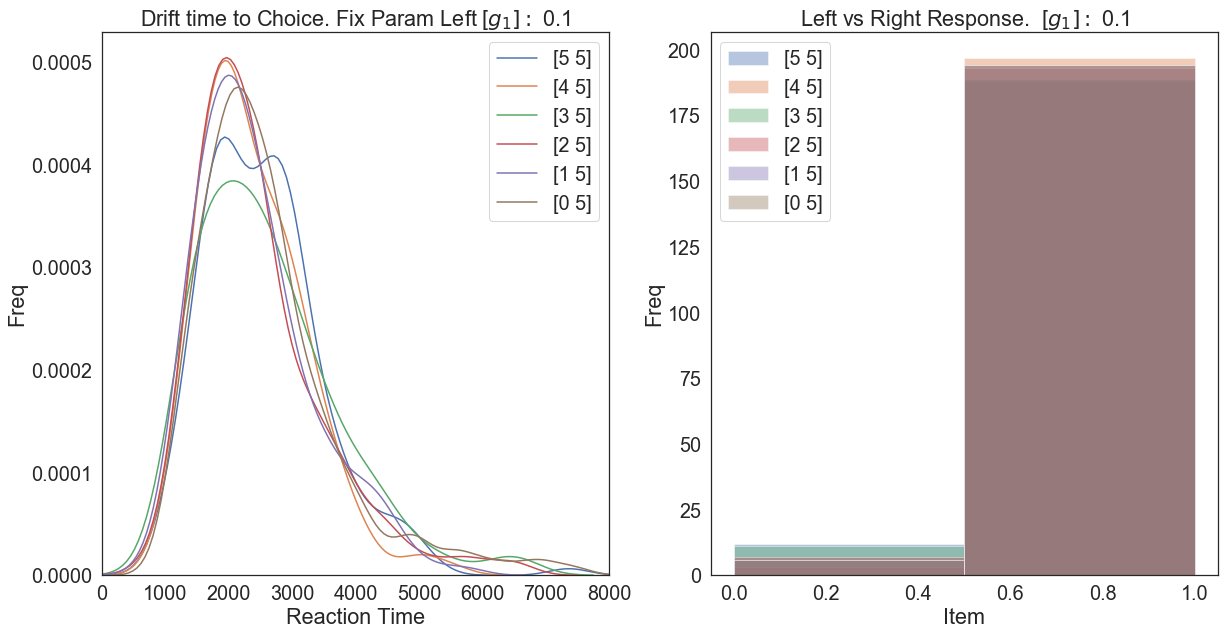

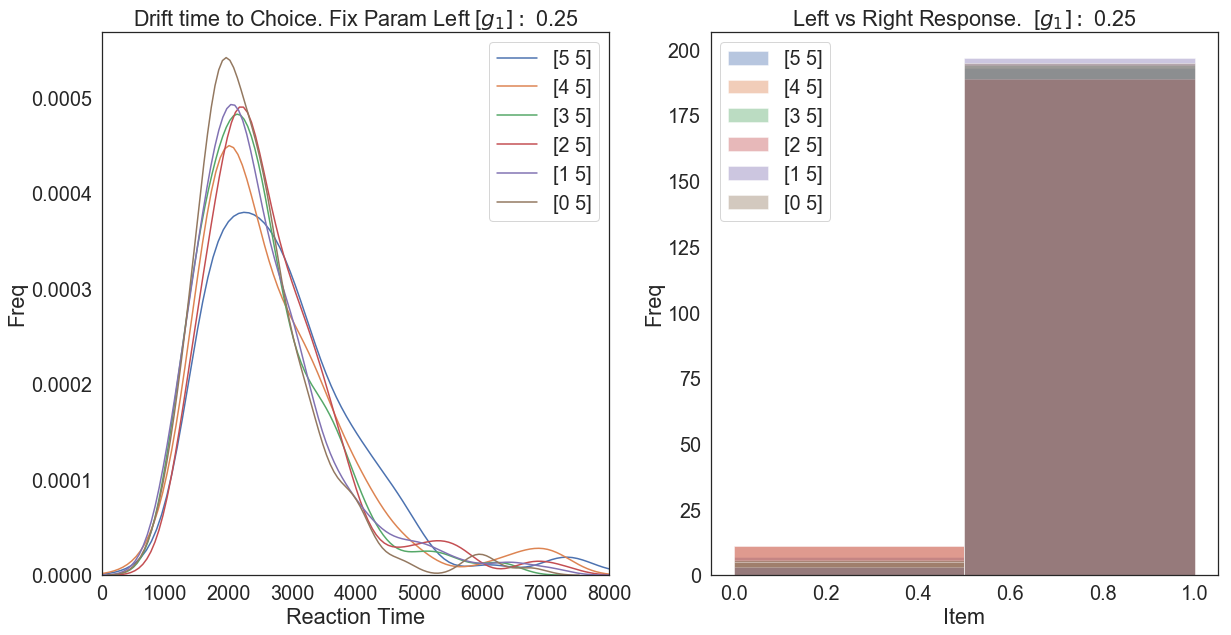

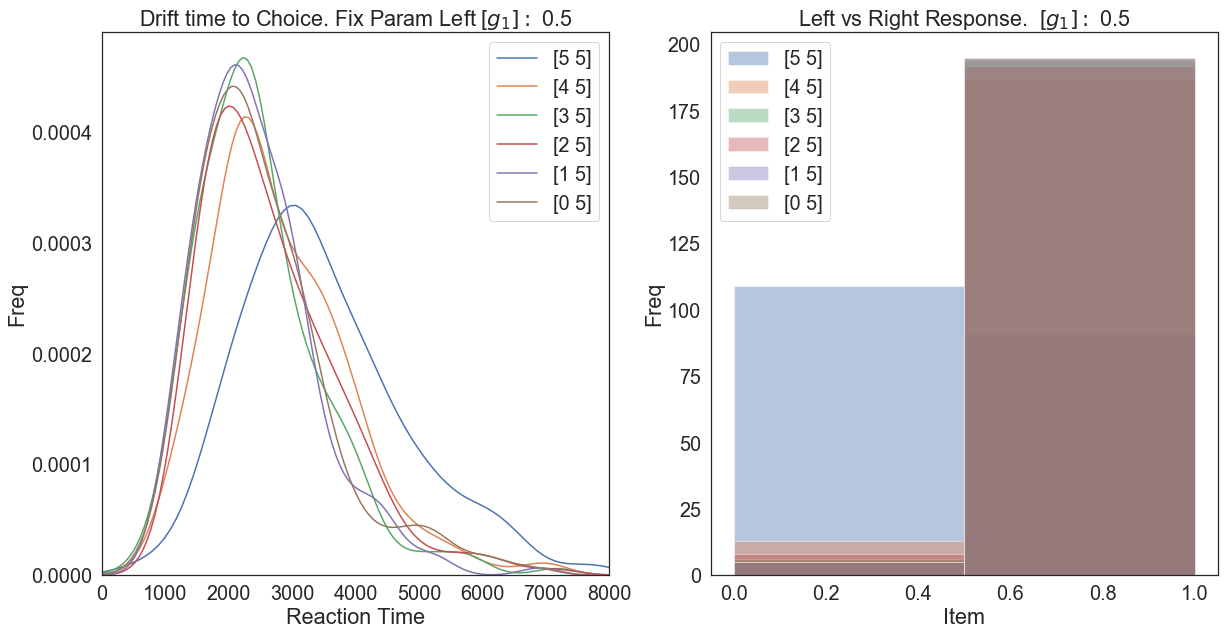

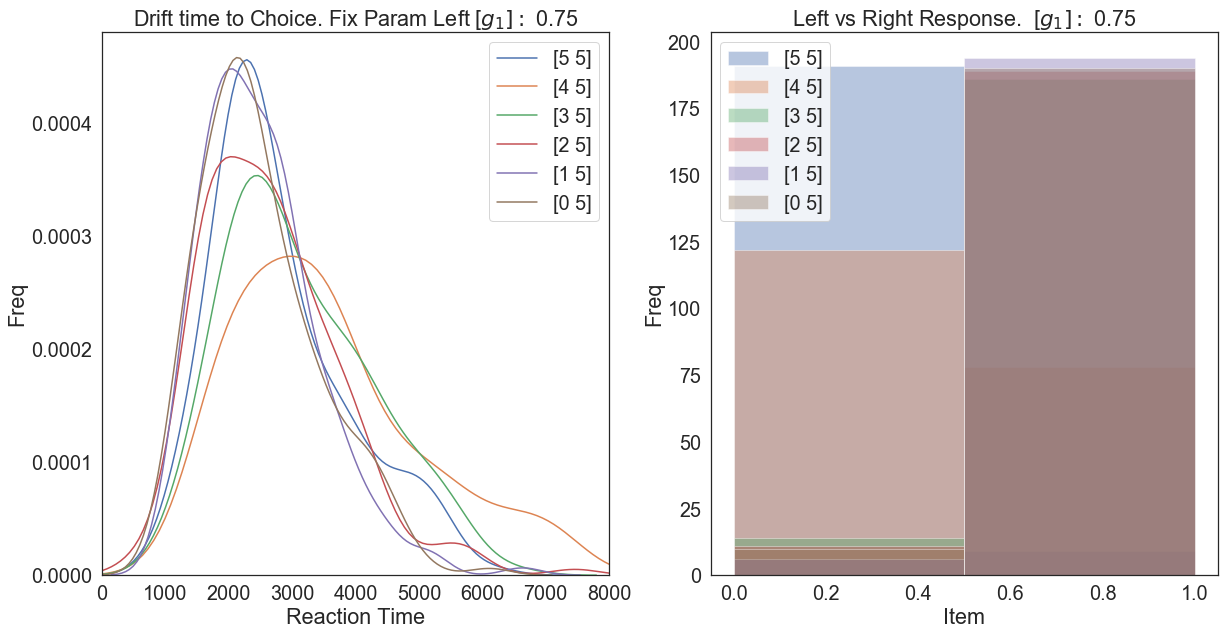

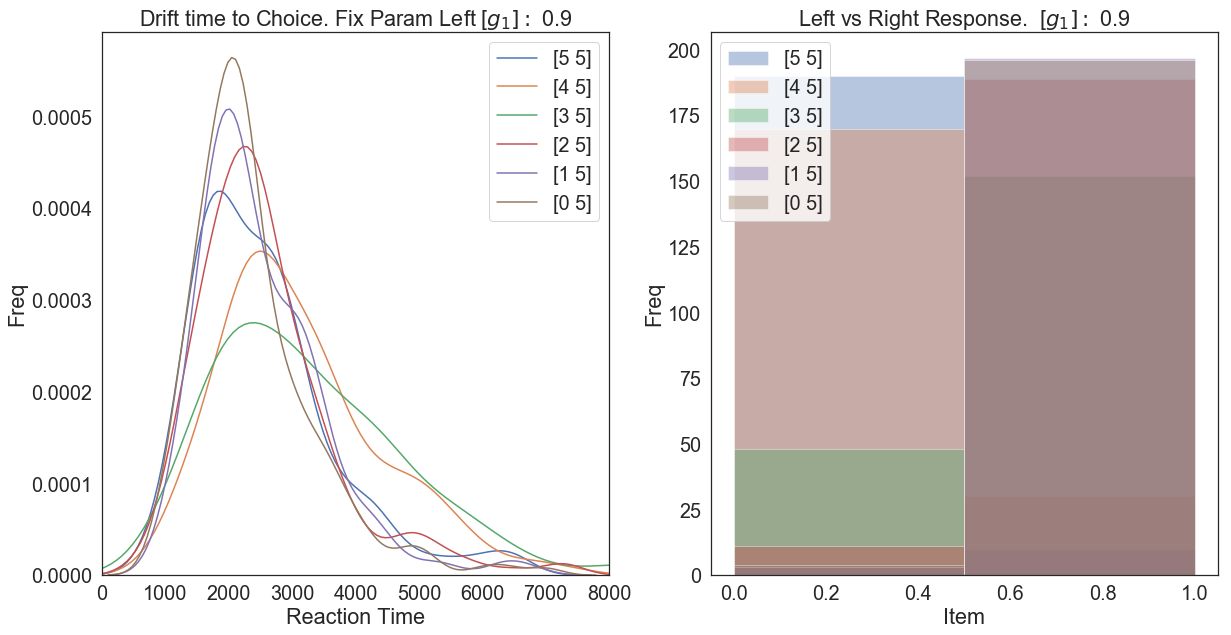

In [37]:
value_tests = np.array([[5,5],[4,5],[3,5],[2,5],[1,5],[0,5]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

v , gamma, s, tau, t0 = parameters
gamma = 0.6
tau = 2
parameters = [v , gamma, s, tau, t0]

n_repeats = 200




for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure(figsize=(20,10))
    sns.set(style='white', font_scale=1.8)


    for trial in range(n_trials):
    
        n_trials, n_items = value_tests.shape
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
                
                choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                            boundary=boundary,
                                            error_weight=error_weight,
                                            error_range=error_range)
    
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                
                running_idx += 1
        plt.subplot(121)        
        ax1 = sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
        plt.subplot(122)
        ax2 =sns.distplot(choices,bins=2, kde = False, hist = True, label=str(value_trial));

    #sns.kdeplot(rts)
    
    ax1.set_title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax1.set(ylabel='Freq', xlabel='Reaction Time', xlim = (0, 8000))

    ax2.set_title("Left vs Right Response. "+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax2.set(ylabel='Freq', xlabel='Item')
    #ax2.xticks([0, 1,], ['Left', 'Right'])


    
    ax1.legend();
    ax2.legend();



## Using DV = 0 at different value magnitudes

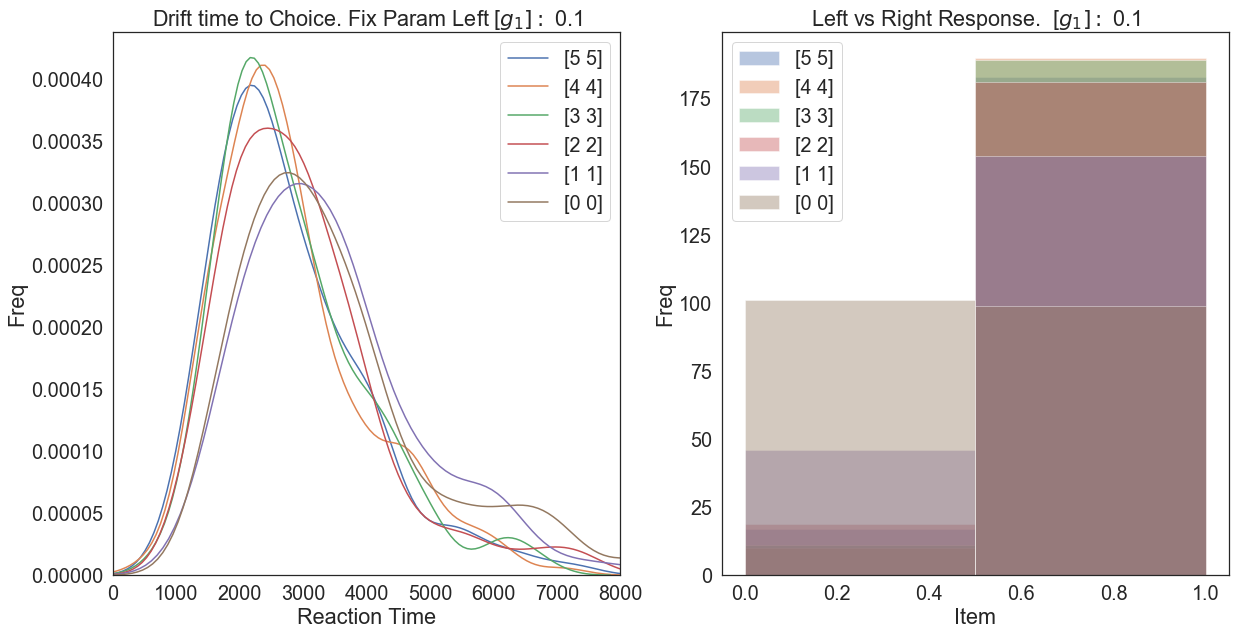

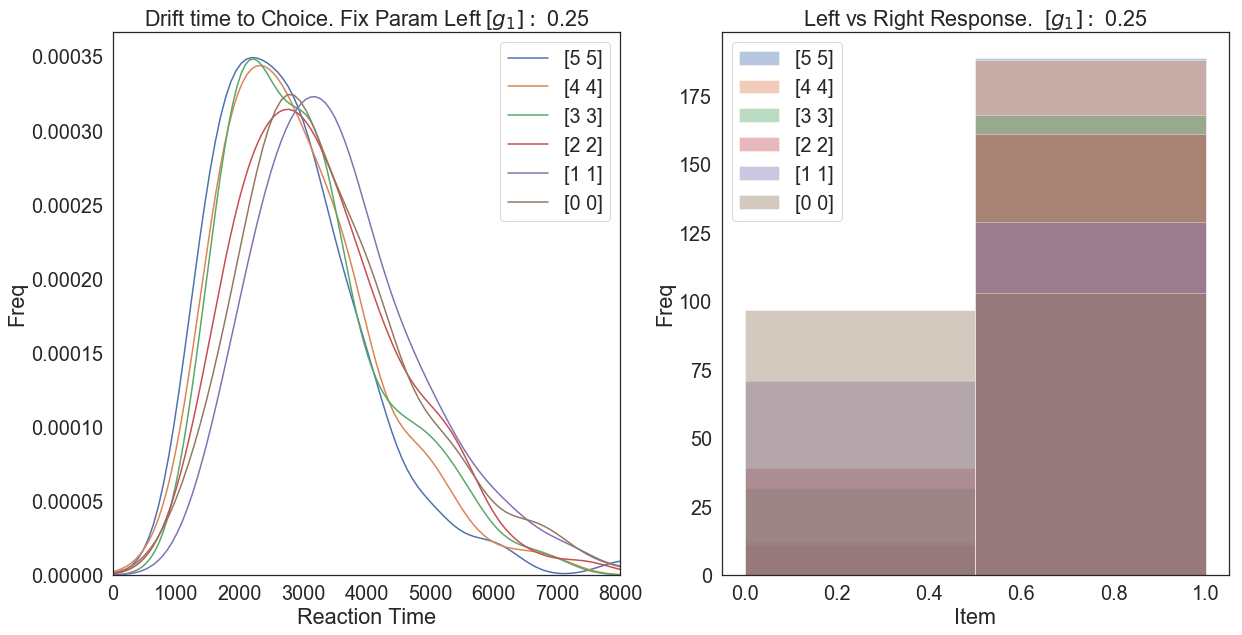

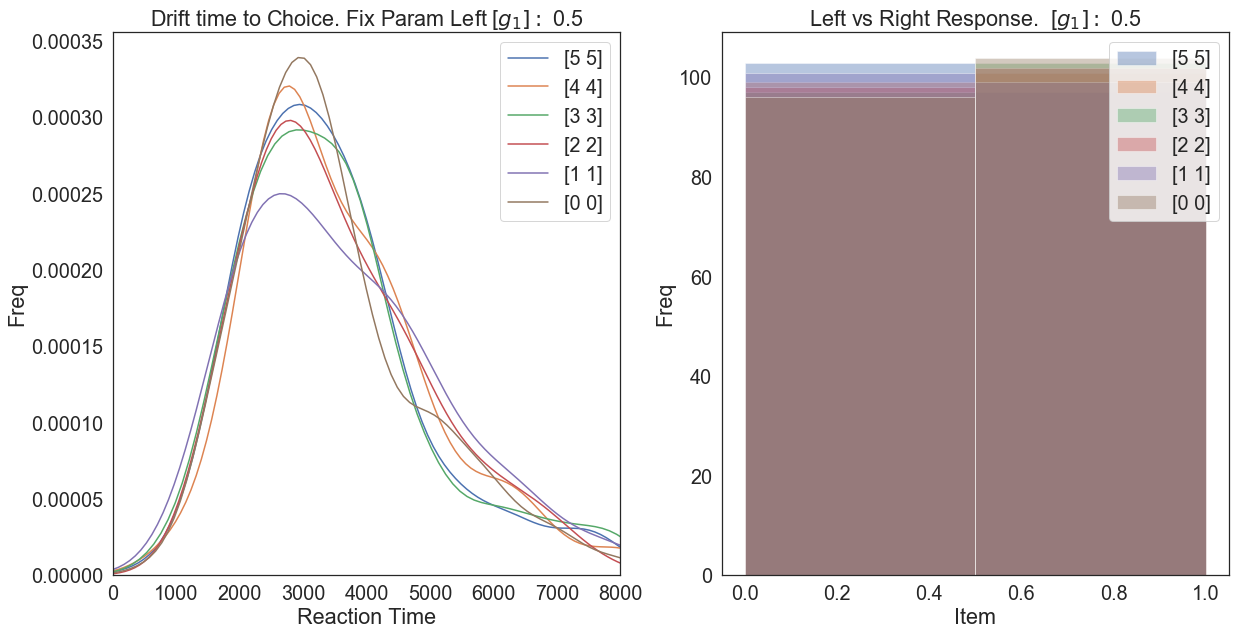

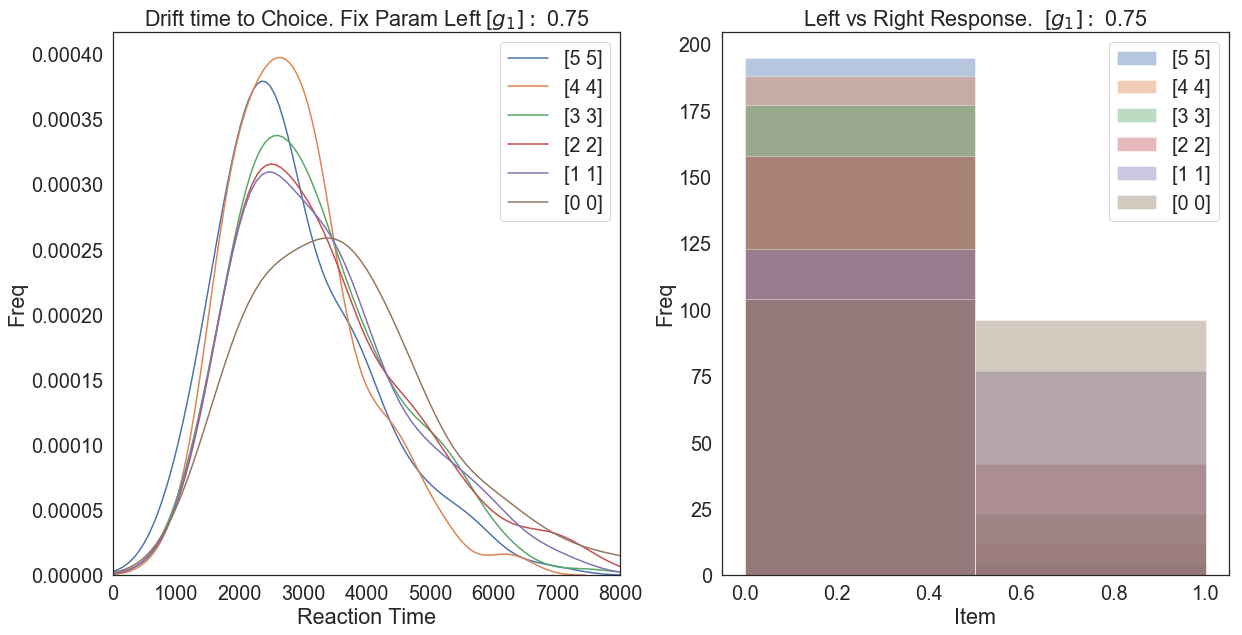

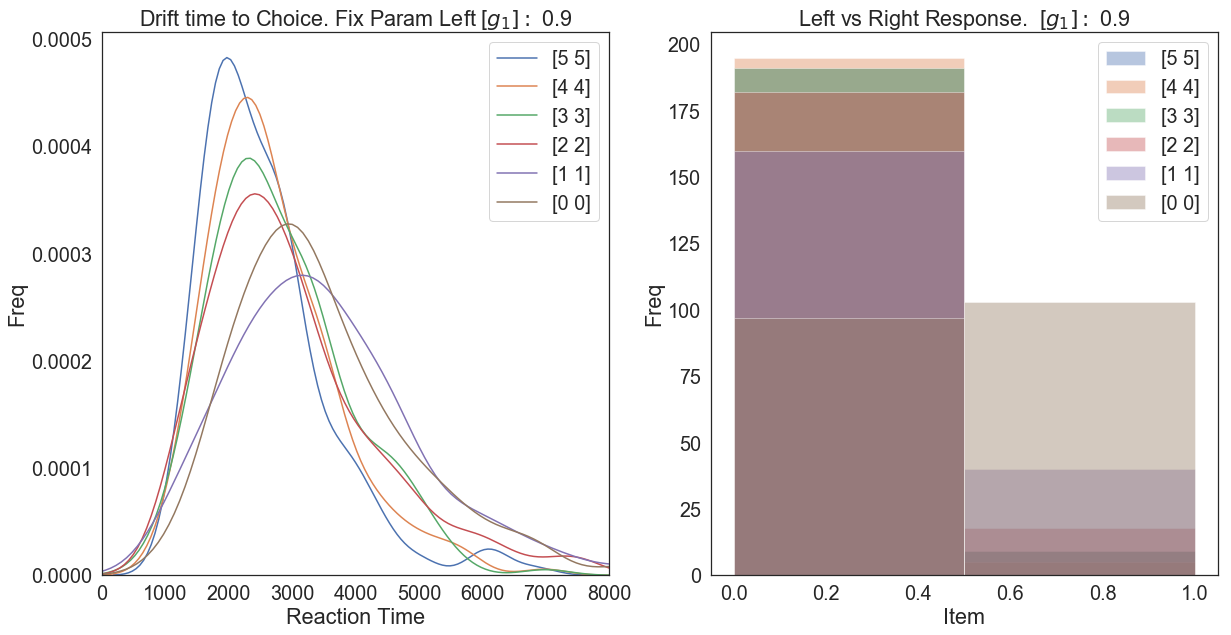

In [32]:
value_tests = np.array([[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

v , gamma, s, tau, t0 = parameters
gamma = 0.6
tau = 2
parameters = [v , gamma, s, tau, t0]

n_repeats = 200




for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure(figsize=(20,10))
    sns.set(style='white', font_scale=1.8)


    for trial in range(n_trials):
    
        n_trials, n_items = value_tests.shape
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
                
                choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                            boundary=boundary,
                                            error_weight=error_weight,
                                            error_range=error_range)
    
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                
                running_idx += 1
        plt.subplot(121)        
        ax1 = sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
        plt.subplot(122)
        ax2 =sns.distplot(choices,bins=2, kde = False, hist = True, label=str(value_trial));

    #sns.kdeplot(rts)
    
    ax1.set_title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax1.set(ylabel='Freq', xlabel='Reaction Time', xlim = (0, 8000))

    ax2.set_title("Left vs Right Response. "+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax2.set(ylabel='Freq', xlabel='Item')
    #ax2.xticks([0, 1,], ['Left', 'Right'])


    
    ax1.legend();
    ax2.legend();



## Using DV = 0 at different value magnitudes

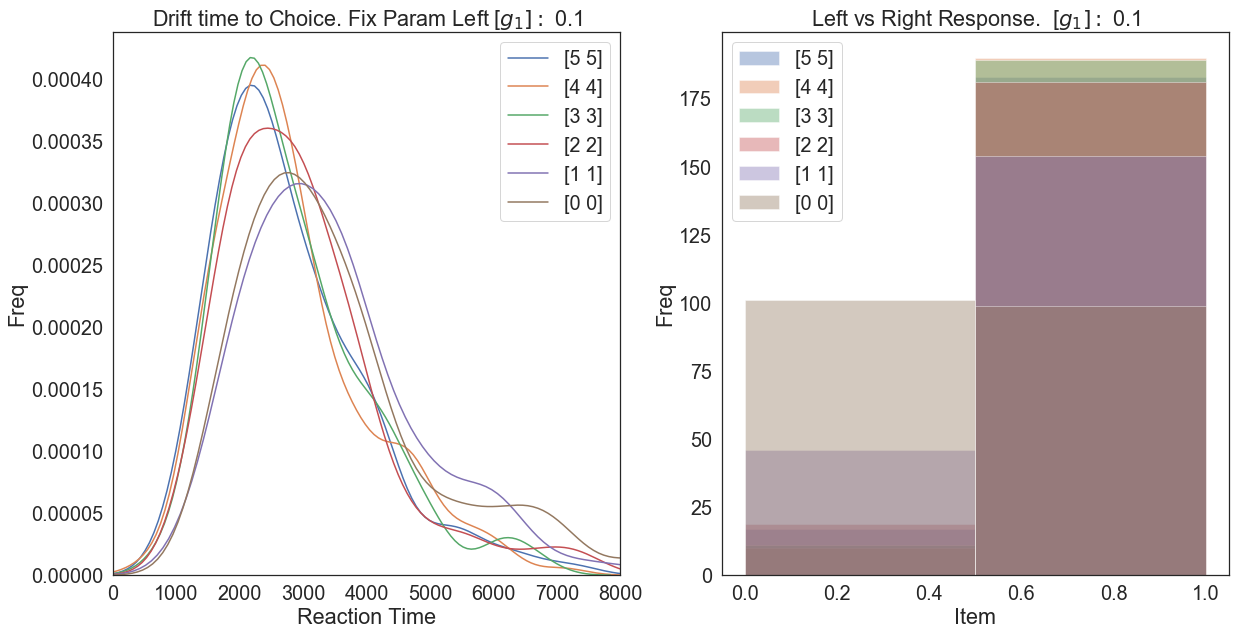

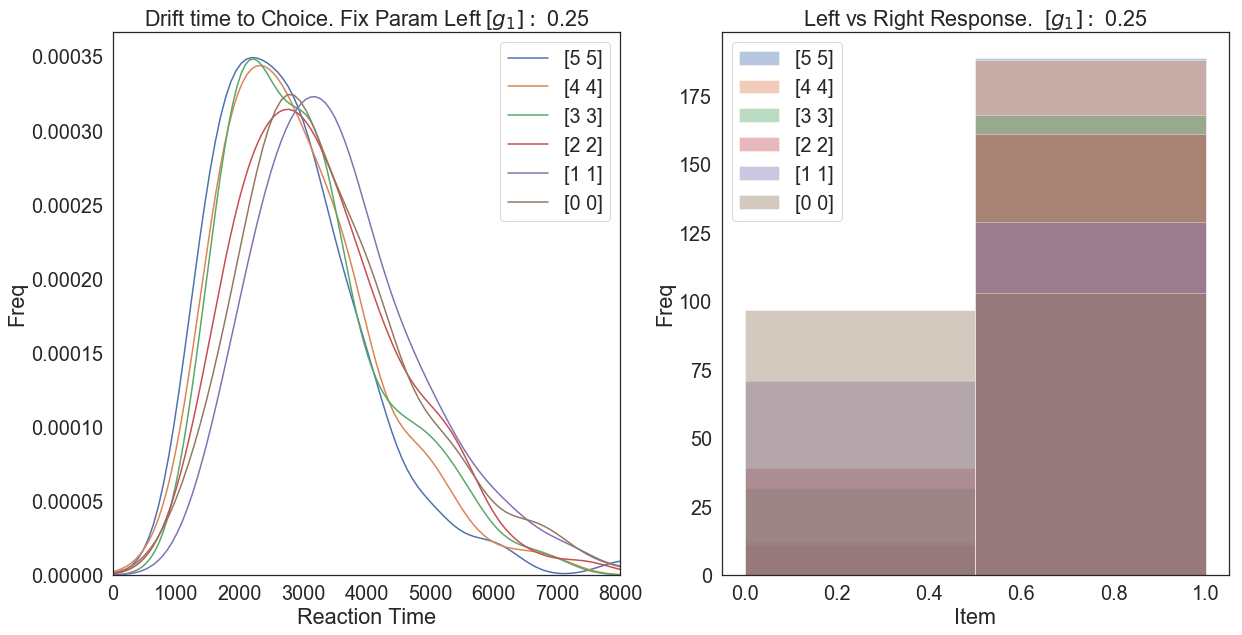

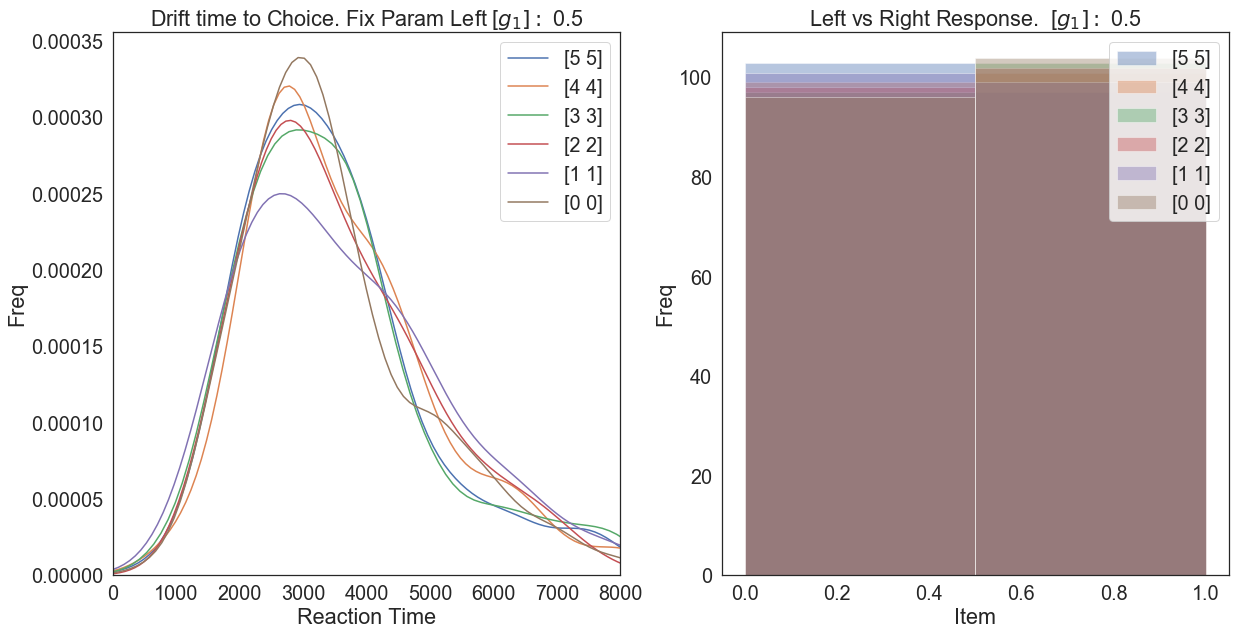

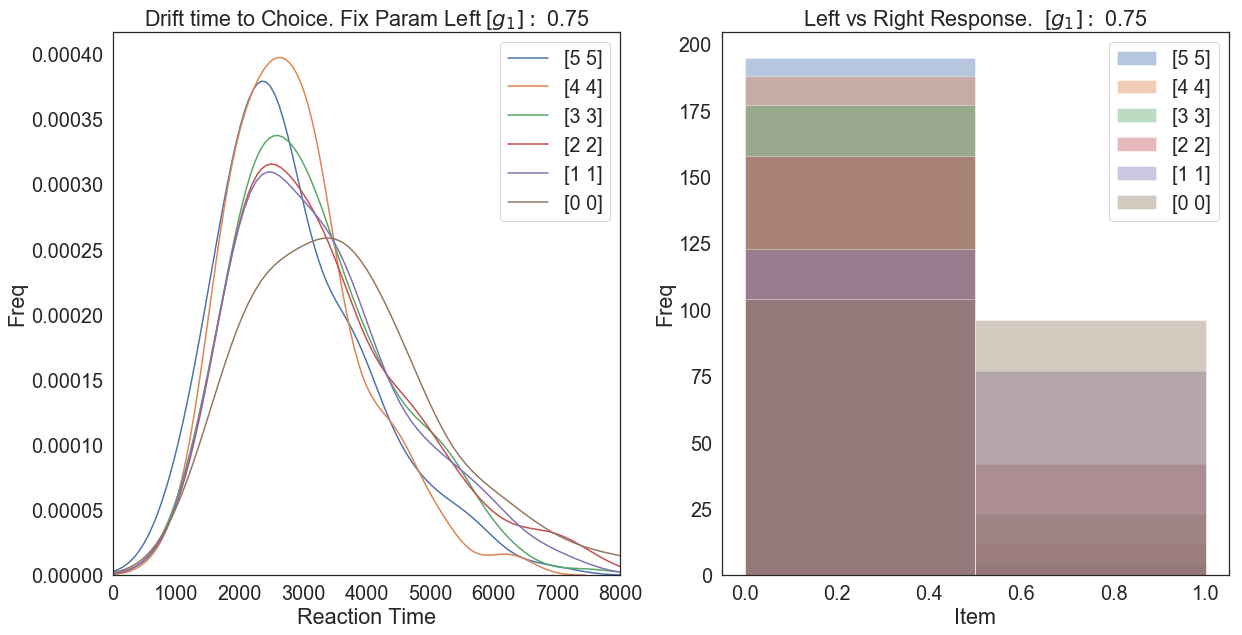

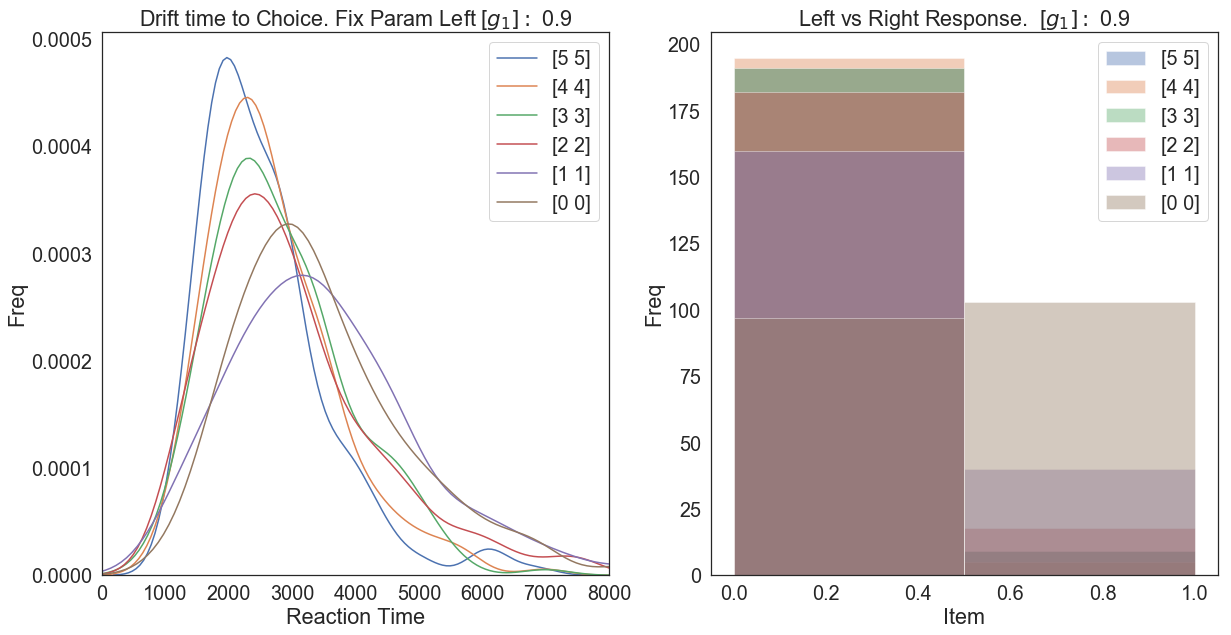

In [32]:
value_tests = np.array([[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

v , gamma, s, tau, t0 = parameters
gamma = 0.6
tau = 2
parameters = [v , gamma, s, tau, t0]

n_repeats = 200




for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure(figsize=(20,10))
    sns.set(style='white', font_scale=1.8)


    for trial in range(n_trials):
    
        n_trials, n_items = value_tests.shape
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
                
                choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                            boundary=boundary,
                                            error_weight=error_weight,
                                            error_range=error_range)
    
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                
                running_idx += 1
        plt.subplot(121)        
        ax1 = sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
        plt.subplot(122)
        ax2 =sns.distplot(choices,bins=2, kde = False, hist = True, label=str(value_trial));

    #sns.kdeplot(rts)
    
    ax1.set_title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax1.set(ylabel='Freq', xlabel='Reaction Time', xlim = (0, 8000))

    ax2.set_title("Left vs Right Response. "+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax2.set(ylabel='Freq', xlabel='Item')
    #ax2.xticks([0, 1,], ['Left', 'Right'])


    
    ax1.legend();
    ax2.legend();



## Attempting to compare between both accumulators

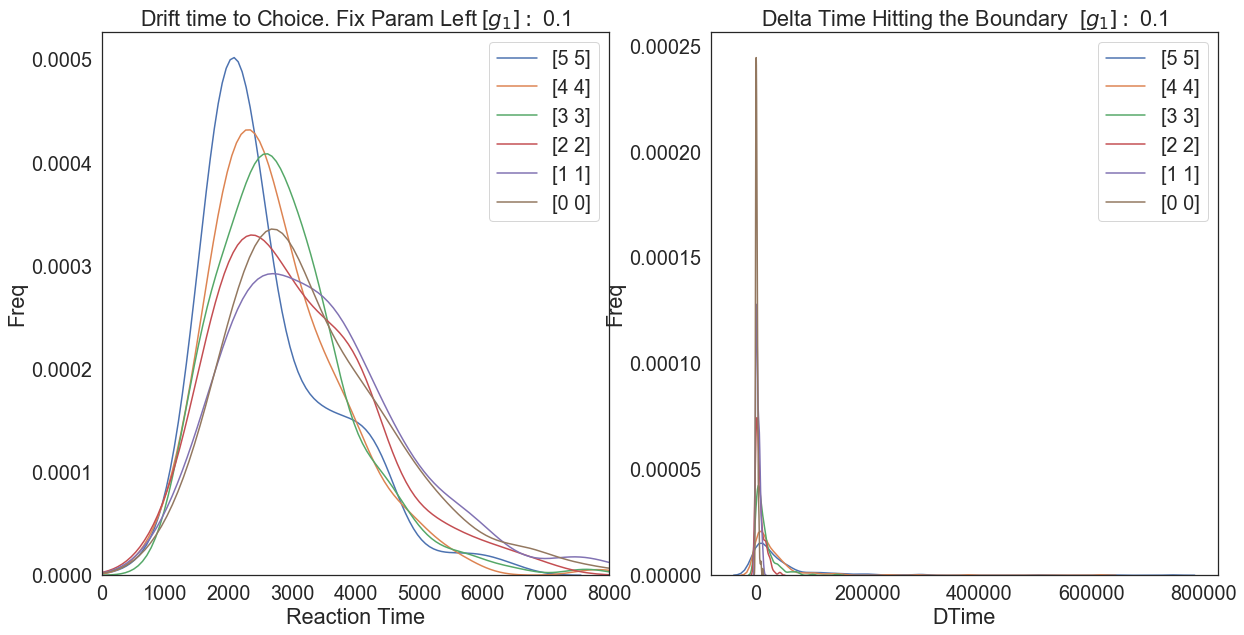

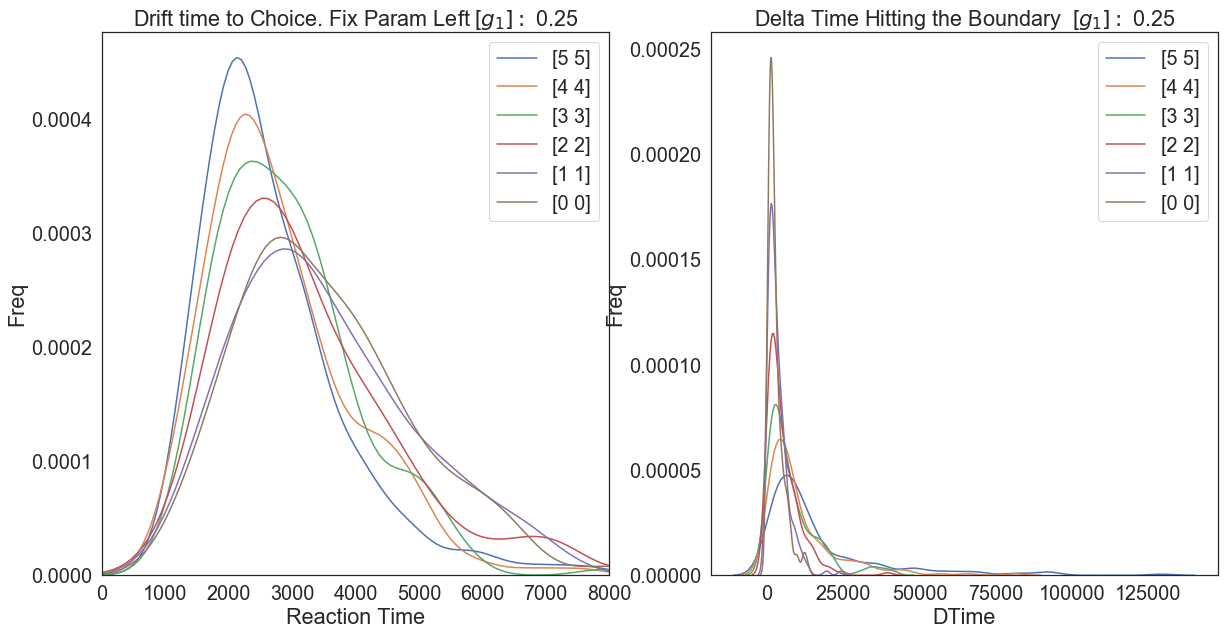

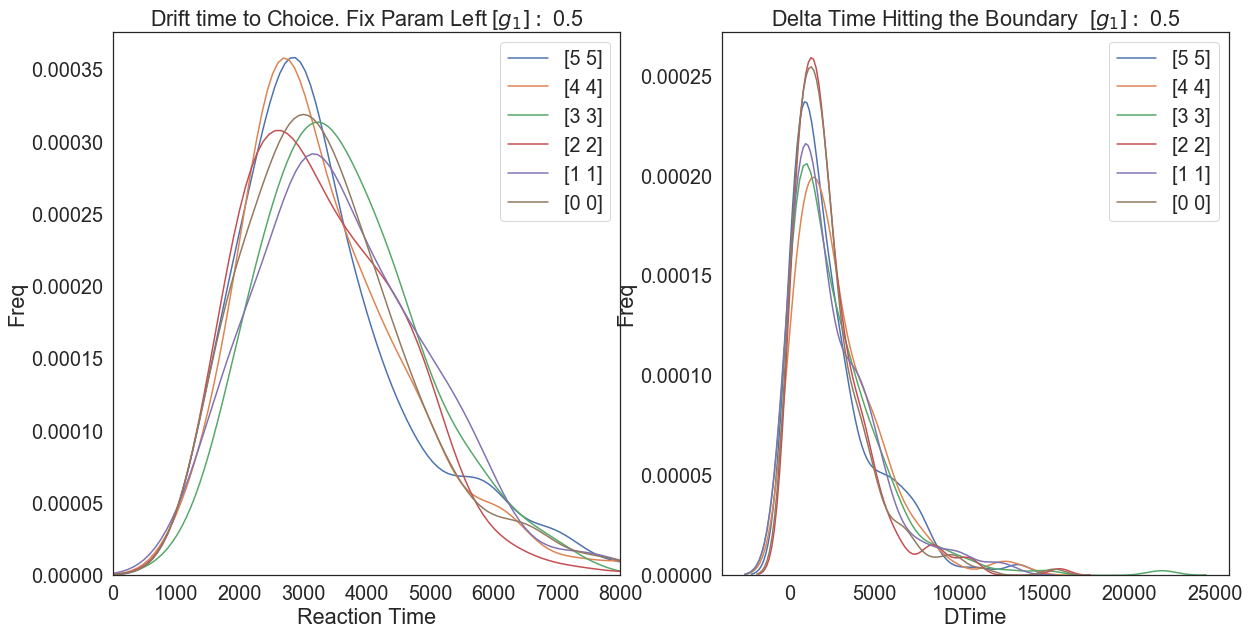

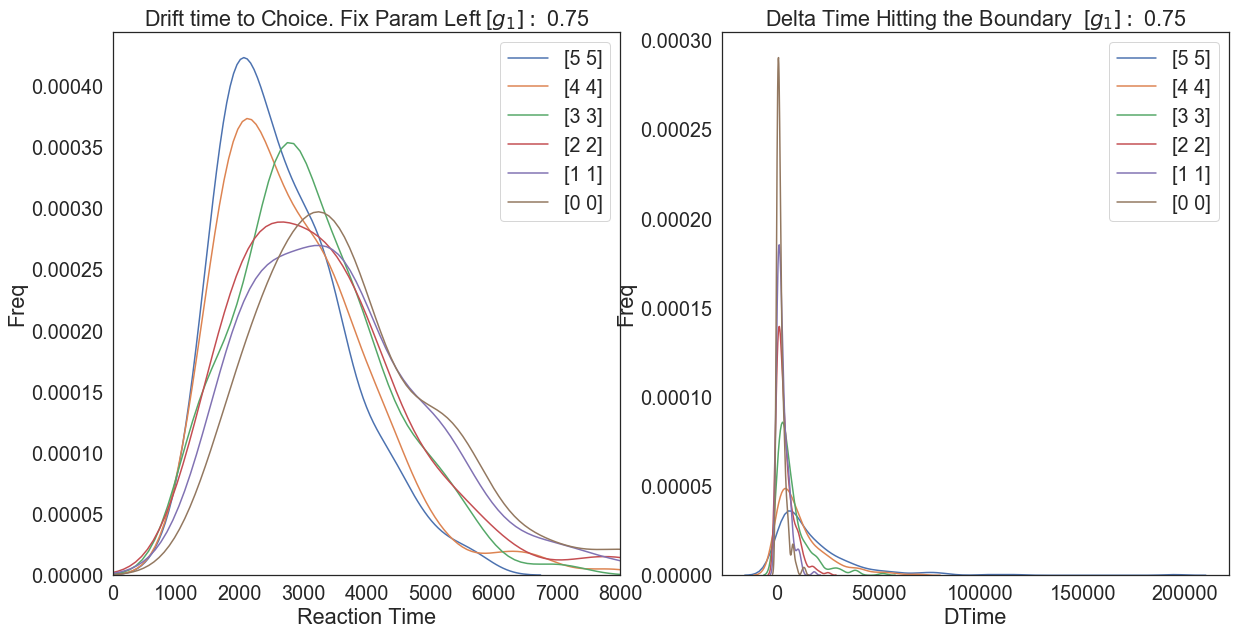

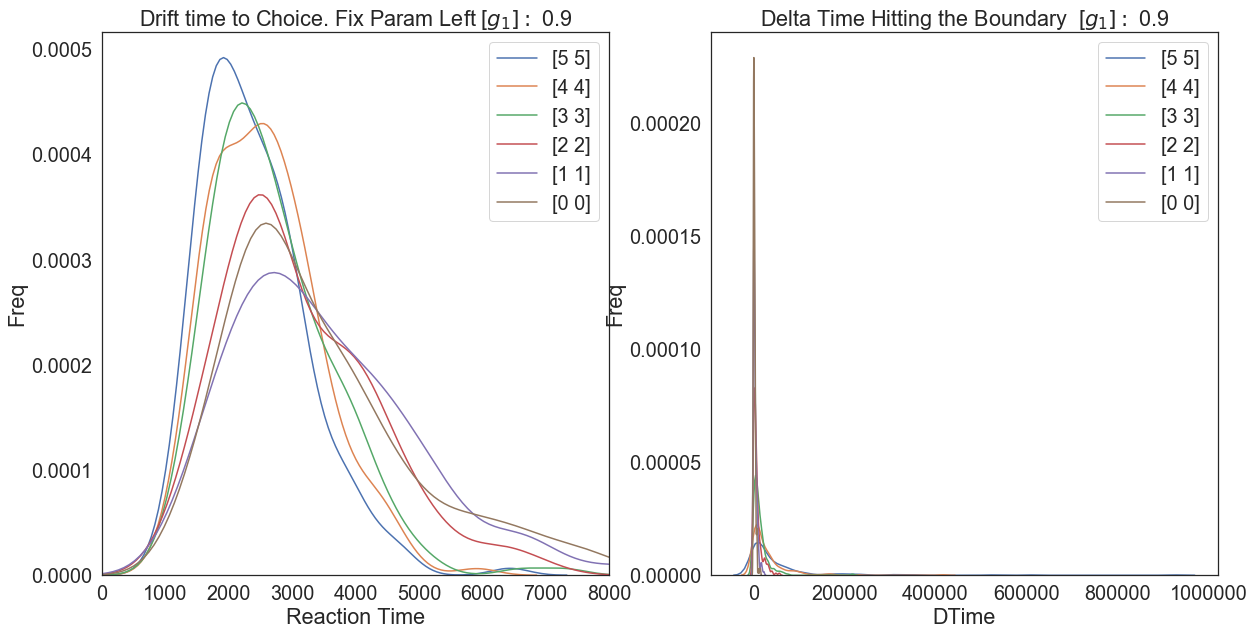

In [49]:
value_tests = np.array([[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

v , gamma, s, tau, t0 = parameters
gamma = 0.6
tau = 2
parameters = [v , gamma, s, tau, t0]

n_repeats = 200




for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure(figsize=(20,10))
    sns.set(style='white', font_scale=1.8)


    for trial in range(n_trials):
    
        n_trials, n_items = value_tests.shape
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        delta_accumulation_time = np.zeros(n_repeats) * np.nan

        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
                
                
                ### Unravelled code for simulate_trial function
                
                v, gamma, s, tau, t0 = parameters
                n_items = len(value_trial)

                if np.random.uniform(0, 1) < error_weight:
                    rt = int(np.random.uniform(*error_range))
                    choice = np.random.choice(n_items)

                else:
                    drifts = glam.simulation.expdrift(v, tau, gamma, value_trial, gaze_trial)

                    FPTs = np.zeros(n_items) * np.nan

                for i in range(n_items):
                    mu = boundary / drifts[i]
                    lam = (boundary / s)**2
                    FPTs[i] = invgauss.rvs(mu=mu/lam, scale=lam)

                choice = np.argmin(FPTs)
                rt = int(np.round(np.min(FPTs) + t0))
                D_acc_time = abs(FPTs[1]-FPTs[0])
                
                #### End of unravelled function
                
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                delta_accumulation_time[running_idx] = D_acc_time
                
                running_idx += 1
                
        plt.subplot(121)        
        ax1 = sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
        
        plt.subplot(122)
        ax2 =sns.distplot(delta_accumulation_time, hist = False, label=str(value_trial));

        
        #plt.subplot(122)
        #ax2 =sns.distplot(choices,bins=2, kde = False, hist = True, label=str(value_trial));

    #sns.kdeplot(rts)
    
    ax1.set_title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax1.set(ylabel='Freq', xlabel='Reaction Time', xlim = (0, 8000))

    ax2.set_title("Delta Time Hitting the Boundary "+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax2.set(ylabel='Freq', xlabel='DTime')
    #ax2.xticks([0, 1,], ['Left', 'Right'])


    
    ax1.legend();
    ax2.legend();



## [END]

## Use various differences

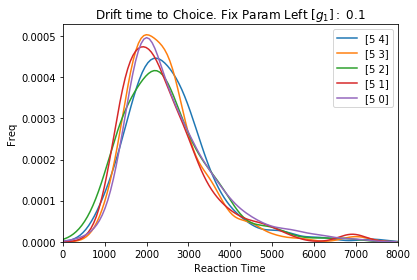

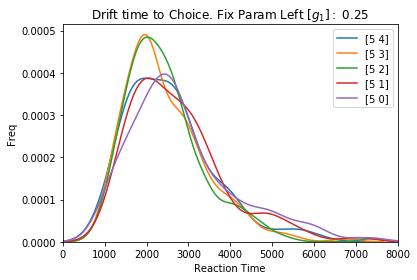

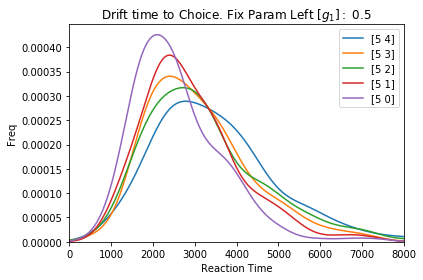

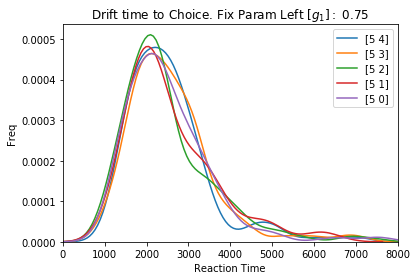

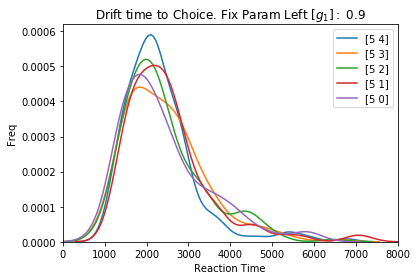

In [178]:
value_tests = np.array([[5,4],[5,3],[5,2],[5,1],[5,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])



v , gamma, s, tau, t0 = parameters
tau = 2
gamma = 0.8 


n_repeats = 200


for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure() 

    for trial in range(n_trials):
    
        n_trials, n_items = value_tests.shape
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
    
                choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                            boundary=boundary,
                                            error_weight=error_weight,
                                            error_range=error_range)
    
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                
                running_idx += 1
                
        sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
    #sns.kdeplot(rts)
    
    plt.title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]) )
    # Set x-axis label
    plt.xlabel('Reaction Time')
    # Set y-axis label
    plt.ylabel('Freq')
    plt.xlim(0, 8000)

    
    plt.legend();
    


In [56]:

# only one trial simulation
value_trial = np.array([5,4])
gaze_trial =np.array([0.76233184,  0.23766816])

v, gamma, s, tau, t0 = parameters
n_items = len(values[trial])

choice, rt = glam.simulation.simulate_trial(parameters,value_trial , gaze_trial,
                                        boundary=boundary,
                                        error_weight=error_weight,
                                        error_range=error_range)

## Attempt with hierarchical model data

In [4]:
test_data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_test'+sufix+'.csv'))
train_data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_train'+sufix+'.csv'))

In [17]:
glam_full = glam.GLAM(train_data)
glam_full.make_model('individual', gamma_bounds=(-1, 1), t0_val=0)
glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))   


Generating single subject models for 33 subjects...


In [18]:

glam_full.exchange_data(test_data)


Replaced attached data (1980 trials) with new data (1980 trials)...


In [19]:
glam_full.estimates


array({'v_sd': 1.1e-05, 't0': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'v_mu': 5.1e-05, 'v': array([  4.50000000e-05,   6.20000000e-05,   5.60000000e-05,
         4.10000000e-05,   6.60000000e-05,   6.00000000e-05,
         6.70000000e-05,   4.40000000e-05,   5.40000000e-05,
         4.50000000e-05,   4.50000000e-05,   5.00000000e-05,
         4.50000000e-05,   4.40000000e-05,   4.30000000e-05,
         4.60000000e-05,   5.00000000e-05,   5.30000000e-05,
         5.50000000e-05,   6.90000000e-05,   4.40000000e-05,
         3.70000000e-05,   6.70000000e-05,   4.20000000e-05,
         3.20000000e-05,   4.90000000e-05,   5.00000000e-05,
         5.60000000e-05,   3.50000000e-05,   4.50000000e-05,
         7.10000000e-05,   5.70000000e-05,   4.20000000e-05]), 's': array([ 0.007405,  0.010183,  0.008641,  0.007556,  0.007086,  0.007743,
        0

In [20]:
subjects = np.unique(glam_full.data['subject'])
subjects

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [21]:
glam_full.predict(n_repeats=50)
#glam.full.estimates

IndexError: too many indices for array

In [28]:
glam_full.estimates.get('v')

AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [ ]:
glam_full.prediction = pd.read_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'))

test_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_test'+sufix+'.csv'))
train_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_train'+sufix+'.csv'))